<a href="https://colab.research.google.com/github/alysawyer/p-recipe/blob/refrigerator/Training_with_fruits_precipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy
from matplotlib import image as mpimg
import time
import copy
from PIL import Image

import locale

# Set the locale to en_US
# locale.setlocale(locale.LC_ALL, 'en_US')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [50]:
#all the possible labels from the dataset
names = ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pineapple', 'strawberries', 'watermelon']

In [66]:
# original paths from our data
train_dir = "/content/sample_data/fruits/train"
test_dir = "/content/sample_data/fruits/test"

train_apple = "/content/sample_data/fruits/train/apple"
train_avocado = "/content/sample_data/fruits/train/avocado"
train_banana = "/content/sample_data/fruits/train/banana"
train_cherry = "/content/sample_data/fruits/train/cherry"
train_kiwi = "/content/sample_data/fruits/train/kiwi"
train_mango = "/content/sample_data/fruits/train/mango"
train_orange = "/content/sample_data/fruits/train/orange"
train_pineapple = "/content/sample_data/fruits/train/pineapple"
train_strawberries = "/content/sample_data/fruits/train/strawberries"
train_watermelon = "/content/sample_data/fruits/train/watermelon"

test_apple = "/content/sample_data/fruits/test/apple"
test_avocado = "/content/sample_data/fruits/test/avocado"
test_banana = "/content/sample_data/fruits/test/banana"
test_cherry = "/content/sample_data/fruits/test/cherry"
test_kiwi = "/content/sample_data/fruits/test/kiwi"
test_mango = "/content/sample_data/fruits/test/mango"
test_orange = "/content/sample_data/fruits/test/orange"
test_pineapple = "/content/sample_data/fruits/test/pineapple"
test_strawberries = "/content/sample_data/fruits/test/strawberries"
test_watermelon = "/content/sample_data/fruits/test/watermelon"

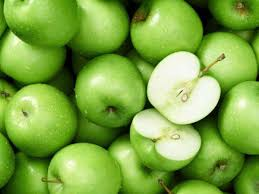

In [69]:
T.ToPILImage()(torchvision.io.read_image("/content/sample_data/fruits/train/apple/img_1001.jpeg"))

In [33]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [72]:
datasets(train_dir, transforms_train)

TypeError: ignored

In [58]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_apple, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

FileNotFoundError: ignored

In [60]:
print('Train dataset size:', len(train_apple))
print('Test dataset size:', len(test_dir))
print('Class names:', names)

Train dataset size: 39
Test dataset size: 32
Class names: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pineapple', 'strawberries', 'watermelon']


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [40]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [54]:
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, len(names))
model = model.to(device)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [55]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running


NameError: ignored

In [ ]:
save_path = 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [ ]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

In [ ]:
# Visualization and result
# constant for classes
classes = names
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True)